<a href="https://colab.research.google.com/github/VarvaraSharutina/mo-ad/blob/main/%D0%BC%D0%BE%D0%B0%D0%B4_%D0%B4%D0%B71.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. Классификация контента Amazon Prime по 10 самым популярным жанрам на основе их характеристик (год выпуска, страна, рейтинг, продолжительность, и т.д.)

1. Чтение данных

In [155]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, StandardScaler


In [156]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("shivamb/amazon-prime-movies-and-tv-shows")

file_path = path + "/amazon_prime_titles.csv"
data_raw = pd.read_csv(file_path)

Using Colab cache for faster access to the 'amazon-prime-movies-and-tv-shows' dataset.


In [157]:
data_raw

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...
...,...,...,...,...,...,...,...,...,...,...,...,...
9663,s9664,Movie,Pride Of The Bowery,Joseph H. Lewis,"Leo Gorcey, Bobby Jordan",NaN,NaN,1940,7+,60 min,Comedy,New York City street principles get an East Si...
9664,s9665,TV Show,Planet Patrol,NaN,"DICK VOSBURGH, RONNIE STEVENS, LIBBY MORRIS, M...",NaN,NaN,2018,13+,4 Seasons,TV Shows,"This is Earth, 2100AD - and these are the adve..."
9665,s9666,Movie,Outpost,Steve Barker,"Ray Stevenson, Julian Wadham, Richard Brake, M...",NaN,NaN,2008,R,90 min,Action,"In war-torn Eastern Europe, a world-weary grou..."
9666,s9667,TV Show,Maradona: Blessed Dream,NaN,"Esteban Recagno, Ezequiel Stremiz, Luciano Vit...",NaN,NaN,2021,TV-MA,1 Season,"Drama, Sports","The series tells the story of Diego Maradona, ..."


In [158]:
data_raw.shape

(9668, 12)

In [159]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7585 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


2. Разбиение данных на тестовую и обучающую выборку

In [160]:
# для дальнейшего предсказания будем использовать только 10 самых популярных жанров
data_raw['primary_genre'] = data_raw['listed_in'].apply(lambda s: s.split(',')[0].strip())
top_genres_count = 10
genre_counts = data_raw['primary_genre'].value_counts()
common_genres = genre_counts.head(top_genres_count).index
data_filtered = data_raw[data_raw['primary_genre'].isin(common_genres)]

In [161]:
from sklearn.model_selection import train_test_split

X = data_filtered.drop(['primary_genre','listed_in', 'date_added', 'show_id'], axis=1)
y = data_filtered['primary_genre']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(6435, 2146)

3. Визуализация данных и вычисление основных характеристик, интерпретация  

Основные статистики для release_year:
count    9668.000000
mean     2008.341849
std        18.922482
min      1920.000000
25%      2007.000000
50%      2016.000000
75%      2019.000000
max      2021.000000
Name: release_year, dtype: float64


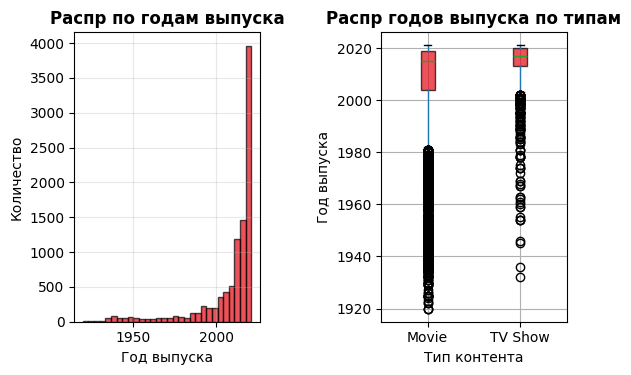

In [162]:
data = data_raw.copy()
print("Основные статистики для release_year:")
release_year_stats = data['release_year'].describe()
print(release_year_stats)

plt.subplot(1, 2, 1)
plt.hist(data['release_year'].dropna(), bins=30, color='#E50914', alpha=0.7, edgecolor='black')
plt.title('Распр по годам выпуска', fontsize=12, fontweight='bold')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
data.boxplot(column='release_year', by='type', ax=plt.gca(), patch_artist=True,
            boxprops=dict(facecolor='#E50914', alpha=0.7))
plt.title('Распр годов выпуска по типам', fontsize=12, fontweight='bold')
plt.suptitle('')
plt.xlabel('Тип контента')
plt.ylabel('Год выпуска')
plt.tight_layout(pad=3.0)
plt.show()

Всего строк с фильмами: 7814
Строк с датами добавления: 16
Число строк с полными данными для корреляционного анализа: 16
Пропущенные значения в numeric_data_raw:
release_year    0
duration_min    0
year_added      0
dtype: int64
    release_year  duration_min  year_added
0           2014         113.0        2021
1           2018         110.0        2021
2           2017          74.0        2021
3           2014          69.0        2021
4           1989          45.0        2021
5           1989          52.0        2021
6           2017          98.0        2021
7           2016         131.0        2021
8           2017          87.0        2021
9           1994          92.0        2021
10          2016          88.0        2021
11          2014          93.0        2021
12          2018          94.0        2021
13          2020          46.0        2021
14          2018          74.0        2021
15          2019          96.0        2021




/tmp/ipython-input-837255062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_dates.loc[:, 'duration_min'] = movies_with_dates['duration'].str.extract(r'(\d+)').astype(float)
/tmp/ipython-input-837255062.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_dates.loc[:, 'year_added'] = movies_with_dates['date_added'].dt.year


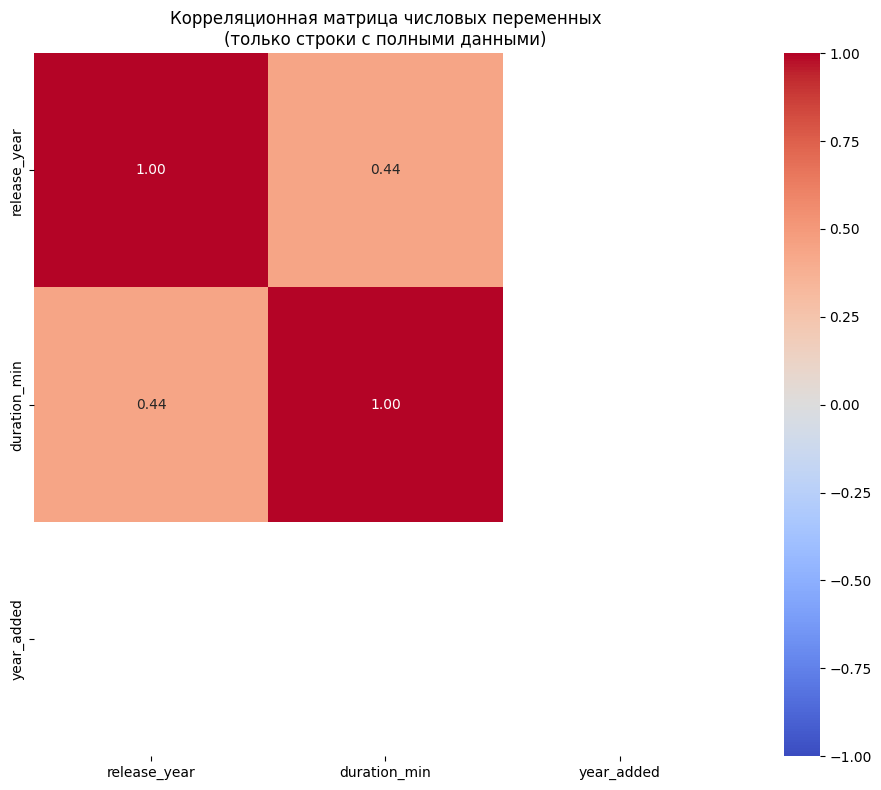


Корреляционная матрица:
              release_year  duration_min  year_added
release_year      1.000000      0.441653         NaN
duration_min      0.441653      1.000000         NaN
year_added             NaN           NaN         NaN


In [163]:
movies = data_raw[data_raw['type'] == 'Movie'].copy()
movies['date_added'] = pd.to_datetime(movies['date_added'], errors='coerce')
movies_with_dates = movies.dropna(subset=['date_added'])
print(f"Всего строк с фильмами: {len(movies)}")
print(f"Строк с датами добавления: {len(movies_with_dates)}")

movies_with_dates.loc[:, 'duration_min'] = movies_with_dates['duration'].str.extract(r'(\d+)').astype(float)
movies_with_dates.loc[:, 'year_added'] = movies_with_dates['date_added'].dt.year

numeric_data_raw = pd.DataFrame()
numeric_data_raw['release_year'] = movies_with_dates['release_year']
numeric_data_raw['duration_min'] = movies_with_dates['duration_min']
numeric_data_raw['year_added'] = movies_with_dates['year_added']

print("Число строк с полными данными для корреляционного анализа:", numeric_data_raw.shape[0])
print("Пропущенные значения в numeric_data_raw:")
print(numeric_data_raw.isnull().sum())
print(numeric_data_raw.head(20))
print("\n")


# Корреляционная матрица
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_data_raw.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', vmin=-1, vmax=1)
plt.title("Корреляционная матрица числовых переменных\n(только строки с полными данными)")
plt.tight_layout()
plt.show()

# Вывод корреляционной матрицы в числовом виде
print("\nКорреляционная матрица:")
print(correlation_matrix)

4. Обработка пропущенных значений

In [164]:
X_train.isnull().sum()

,0
type,0
title,0
director,1281
cast,773
country,5979
release_year,0
rating,251
duration,0
description,0


In [165]:
cols_to_fill = ['director', 'cast', 'country', 'rating', 'duration']
for col in cols_to_fill:
    X_train[col] = X_train[col].fillna('unknown')
    X_test[col] = X_test[col].fillna('unknown')

print("\nПосле обработки пропусков:")
X_train.isnull().sum()


После обработки пропусков:


,0
type,0
title,0
director,0
cast,0
country,0
release_year,0
rating,0
duration,0
description,0


5. Обработка категориальных признаков

In [166]:
X_train['type'] = X_train['type'].astype('category')
X_train['rating'] = X_train['rating'].astype('category')
X_test['type'] = X_test['type'].astype('category')
X_test['rating'] = X_test['rating'].astype('category')

In [167]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
enc = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
enc.fit(X_train[['type','rating']])

OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

In [168]:
dummies = pd.DataFrame(enc.transform(X_train[['type', 'rating']]),
                       columns=enc.get_feature_names_out(), index=X_train.index)

countries_split = X_train['country'].str.split(',').apply(
    lambda x: [item.strip() for item in x] if isinstance(x, list) else []
)
mlb = MultiLabelBinarizer()
country_encoded = mlb.fit_transform(countries_split)
country_df = pd.DataFrame(country_encoded,
                         columns=mlb.classes_,
                         index=X_train.index)
country_df = country_df.add_prefix('country_')

dummies = pd.concat([dummies, country_df], axis=1)
dummies.head()

,type_TV Show,rating_13+,rating_16,rating_16+,rating_18+,rating_7+,rating_AGES_16_,rating_AGES_18_,rating_ALL,rating_G,...,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Thailand,country_United Arab Emirates,country_United Kingdom,country_United States,country_unknown
1939,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2450,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3465,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
5346,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7614,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [169]:
X_train = pd.concat((X_train, dummies), axis=1).drop(['type', 'rating', 'country'], axis=1)

In [170]:
X_train.head()

,title,director,cast,release_year,duration,description,type_TV Show,rating_13+,rating_16,rating_16+,...,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_Switzerland,country_Thailand,country_United Arab Emirates,country_United Kingdom,country_United States,country_unknown
1939,Killer Mysteries,unknown,Owen Thomas,2018,1 Season,Killer Mysteries investigates the world's most...,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2450,Fluffy's Food Adventures,unknown,"Gabriel Iglesias, Rick Gutierrez, Martin Moreno",2017,3 Seasons,You Hungry? Well Fluffy is-and he's taking his...,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3465,36 Husbands,Michael Glover,"Christa Pasch, Roberta Bianchini, Nadine Nourn...",2020,83 min,"36 Husbands is a mystical, musical, Kung Fu sp...",0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
5346,Taqdeerwala,K. Muralimohana Rao,"Venkatesh Daggubati, Raveena Tandon, Kader Kha...",1995,160 min,"When the Book of Destiny gets stolen, Yamraj t...",0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7614,Ogre,James Snider,"Carmen Piroli, Maria Petrano, Chen Tsung, Jaco...",2019,70 min,"Once cast, the Trollnet promises to bring chao...",0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


6. Нормализация

In [171]:
features = ['release_year']

# Масштабируем, чтобы все признаки были в одном масштабе
data_raw_processed = data_raw.copy()
scaler = StandardScaler()
data_raw_scaled = data_raw_processed.copy()
data_raw_scaled[features] = scaler.fit_transform(data_raw_processed[features])

print("До нормализации (первые 10 строк):")
print(data_raw_processed[features].head(10))
print("\nПосле нормализации (первые 10 строк):")
print(data_raw_scaled[features].head(10))

До нормализации (первые 10 строк):
   release_year
0          2014
1          2018
2          2017
3          2014
4          1989
5          1989
6          2017
7          2016
8          2017
9          1994

После нормализации (первые 10 строк):
   release_year
0      0.299033
1      0.510433
2      0.457583
3      0.299033
4     -1.022215
5     -1.022215
6      0.457583
7      0.404733
8      0.457583
9     -0.757966


7. Запуск классификатора

In [172]:
# добрабытываем данные тестовой выборки
dummies = pd.DataFrame(enc.transform(X_test[['type', 'rating']]),
                       columns=enc.get_feature_names_out(), index=X_test.index)

test_countries_split = X_test['country'].str.split(',').apply(
    lambda x: [item.strip() for item in x] if isinstance(x, list) else []
)
test_country_encoded = mlb.transform(test_countries_split)
test_country_df = pd.DataFrame(test_country_encoded,
                              columns=mlb.classes_,
                              index=X_test.index)
test_country_df = test_country_df.add_prefix('country_')

X_test = pd.concat((X_test, dummies), axis=1).drop(['type', 'rating', 'country'], axis=1)

X_train['combined_text'] = (
    X_train['description'].fillna('') + ' ' +
    X_train['title'].fillna('') + ' ' +
    X_train['director'].fillna('') + ' ' +
    X_train['cast'].fillna('') + ' ' +
    X_train['duration'].fillna('')
)

X_test['combined_text'] = (
    X_test['description'].fillna('') + ' ' +
    X_test['title'].fillna('') + ' ' +
    X_test['director'].fillna('') + ' ' +
    X_test['cast'].fillna('') + ' ' +
    X_test['duration'].fillna('')
)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_text = tfidf.fit_transform(X_train['combined_text'])
X_test_text = tfidf.transform(X_test['combined_text'])

svd = TruncatedSVD(n_components=150, random_state=42)
X_train_svd = svd.fit_transform(X_train_text)
X_test_svd = svd.transform(X_test_text)

text_columns_to_drop = ['description', 'title', 'director', 'cast', 'duration', 'combined_text']
X_train = X_train.drop([col for col in text_columns_to_drop if col in X_train.columns], axis=1)
X_test = X_test.drop([col for col in text_columns_to_drop if col in X_test.columns], axis=1)

scaler = StandardScaler()
year_train = scaler.fit_transform(X_train[['release_year']])
year_test = scaler.transform(X_test[['release_year']])

X_train_full = np.hstack([X_train_svd, X_train.values, year_train])
X_test_full = np.hstack([X_test_svd, X_test.values, year_test])
if isinstance(X_train_full, np.ndarray):
    X_train_full = pd.DataFrame(X_train_full)
if isinstance(X_test_full, np.ndarray):
    X_test_full = pd.DataFrame(X_test_full)
common_cols = X_train_full.columns.intersection(X_test_full.columns)
X_train_full = X_train_full[common_cols]
X_test_full = X_test_full[common_cols]

rf = RandomForestClassifier( n_estimators=300, max_depth=15, class_weight='balanced', n_jobs=-1, random_state=42 )
common_cols = X_train_full.columns.intersection(X_test_full.columns)
X_train_full = X_train_full[common_cols]
X_test_full = X_test_full[common_cols]

print("Количество общих признаков:", len(common_cols))

rf.fit(X_train_full, y_train)
# Тестовые предсказания
y_pred = rf.predict(X_test_full)

# Тренировочные предсказания
y_train_pred = rf.predict(X_train_full)

print("=== Обучающая выборка ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1 (macro):", f1_score(y_train, y_train_pred, average='macro'))

print("\n=== Тестовая выборка (основной жанр) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average='macro'))

print("\nClassification report:\n")

print(classification_report(y_test, y_pred, zero_division=0))



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Austria', 'Hong Kong', 'Hungary', 'Iran', 'Portugal'] will be ignored
  warnings.warn(


Количество общих признаков: 177
=== Обучающая выборка ===
Accuracy: 0.9956487956487956
F1 (macro): 0.9958656142786712

=== Тестовая выборка (основной жанр) ===
Accuracy: 0.4962721342031687
F1 (macro): 0.48015173981491976

Classification report:

              precision    recall  f1-score   support

      Action       0.44      0.49      0.46       377
   Animation       0.63      0.59      0.61       123
        Arts       0.75      0.61      0.67       107
      Comedy       0.56      0.30      0.39       411
 Documentary       0.51      0.68      0.58       229
       Drama       0.47      0.60      0.52       555
      Horror       0.53      0.32      0.40       142
        Kids       0.71      0.53      0.61        85
    Suspense       0.71      0.11      0.19        47
    TV Shows       0.28      0.56      0.37        70

    accuracy                           0.50      2146
   macro avg       0.56      0.48      0.48      2146
weighted avg       0.52      0.50      0.49      2

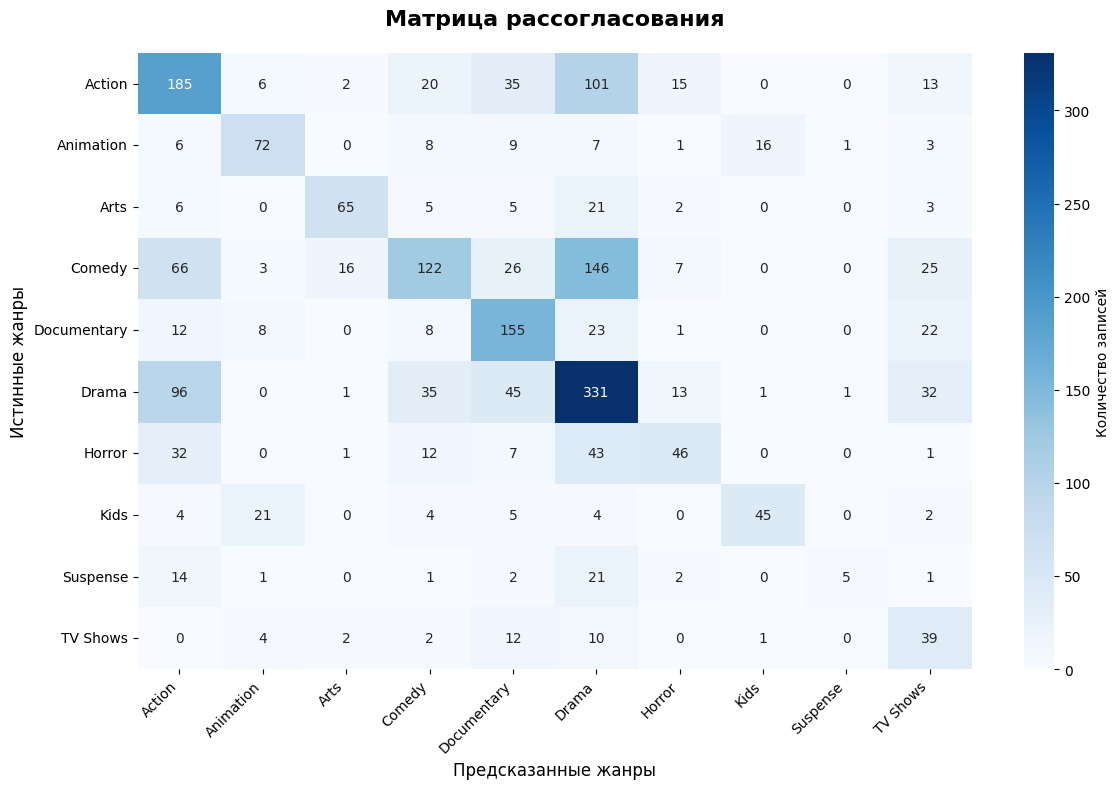

In [173]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=rf.classes_,
            yticklabels=rf.classes_,
            cbar_kws={'label': 'Количество записей'})

plt.title('Матрица рассогласования', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Предсказанные жанры', fontsize=12)
plt.ylabel('Истинные жанры', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()